In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir_ = Path('/content/drive/MyDrive/PJ4/data')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/PJ4/data/airplane/airpl...,airplane
1,/content/drive/MyDrive/PJ4/data/fruit/fruit_08...,fruit
2,/content/drive/MyDrive/PJ4/data/fruit/fruit_05...,fruit
3,/content/drive/MyDrive/PJ4/data/cat/cat_0609.jpg,cat
4,/content/drive/MyDrive/PJ4/data/fruit/fruit_09...,fruit


In [ ]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 6899

Number of different labels: 8

Labels: ['airplane' 'fruit' 'cat' 'car' 'person' 'flower' 'motorbike' 'dog']


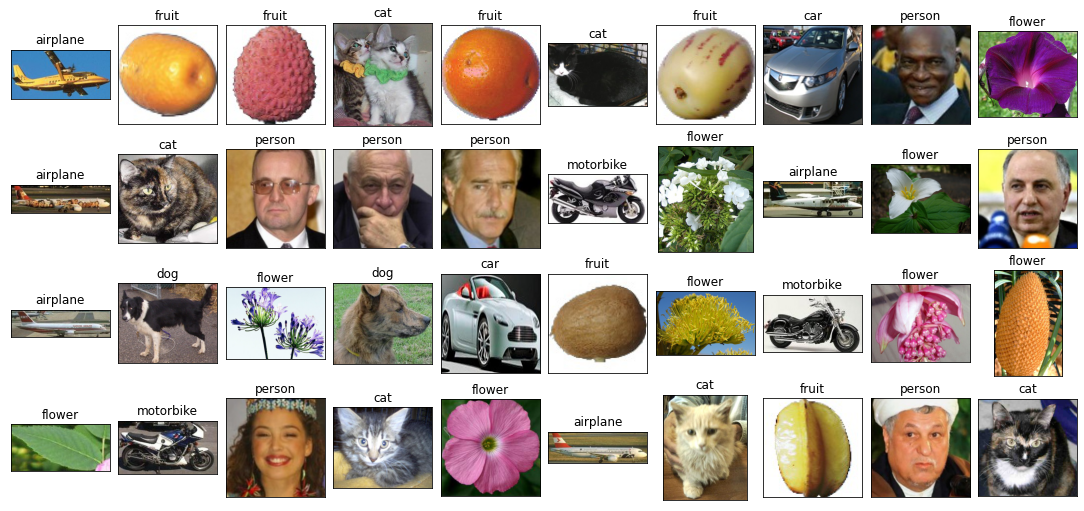

In [ ]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

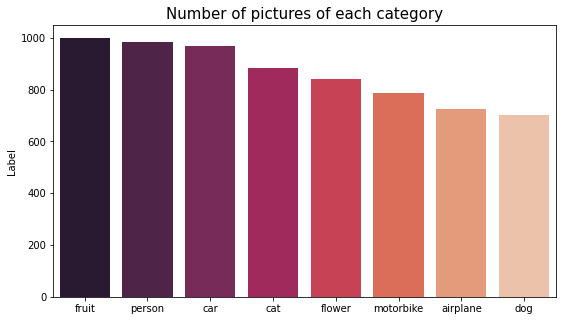

In [ ]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [ ]:
# Training/test split 이미지 데이터 분류

train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((6209, 2), (690, 2))

베이스라인모델


In [ ]:
#베이스라인모델
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/PJ4/natural_images',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/PJ4/natural_images',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.


In [ ]:
# Initialising the CNN              //  CNN모델로 베이스라인모델링
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=8, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [ ]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
173/173 [==============================] - 171s 965ms/step - loss: 0.6678 - accuracy: 0.7673 - val_loss: 0.3303 - val_accuracy: 0.8802
Epoch 2/10
173/173 [==============================] - 160s 924ms/step - loss: 0.1985 - accuracy: 0.9258 - val_loss: 0.2717 - val_accuracy: 0.8903
Epoch 3/10
173/173 [==============================] - 159s 921ms/step - loss: 0.1090 - accuracy: 0.9640 - val_loss: 0.2633 - val_accuracy: 0.9034
Epoch 4/10
173/173 [==============================] - 165s 955ms/step - loss: 0.0489 - accuracy: 0.9844 - val_loss: 0.2844 - val_accuracy: 0.9020
Epoch 5/10
173/173 [==============================] - 159s 921ms/step - loss: 0.0358 - accuracy: 0.9895 - val_loss: 0.3700 - val_accuracy: 0.8925
Epoch 6/10
173/173 [==============================] - 162s 938ms/step - loss: 0.0249 - accuracy: 0.9929 - val_loss: 0.3171 - val_accuracy: 0.9034
Epoch 7/10
173/173 [==============================] - 163s 940ms/step - loss: 0.0211 - accuracy: 0.9949 - val_loss: 0.3636 -

accuracy : 1.0000
val_accuracy : 0.9252

In [ ]:
def create_gen(): #모델 성능 높이기 데이터증강으로 이미지로드
    
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', 
        y_col='Label', 
        target_size=(224, 224), 
        color_mode='rgb', # 이미지 채널
        class_mode='categorical', # Label값
        batch_size=32,
        shuffle=True, 
        seed=0,
        subset='training', 
        rotation_range=30, 
        zoom_range=0.15, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        shear_range=0.15, 
        horizontal_flip=True, 
        fill_mode="nearest"
        
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
#전이학습을 사용하여 모델성능 상향해보기
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# 최소화
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False .
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(8, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
  
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]


Found 5589 validated image filenames belonging to 8 classes.
Found 620 validated image filenames belonging to 8 classes.
Found 690 validated image filenames belonging to 8 classes.


DenseNet121          trained in 2371.46 sec
9420800/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 265.32 sec
74850304/74836368 [==============================] - 3s 0us/step
DenseNet201          trained in 1450.21 sec
16719872/16705208 [==============================] - 0s 0us/step
EfficientNetB0       trained in 373.32 sec
27033600/27018416 [==============================] - 1s 0us/step
EfficientNetB1       trained in 572.99 sec
87924736/87910968 [==============================] - 1s 0us/step
InceptionV3          trained in 664.66 sec
12697600/12683000 [==============================] - 0s 0us/step
MobileNetV3Large     trained in 215.19 sec
234561536/234545216 [==============================] - 3s 0us/step
ResNet152V2          trained in 2553.38 sec
94781440/947657

In [ ]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

**DenseNet121 has a 99.57% accuracy on the test set**
**MobileNetV2 has a 99.57% accuracy on the test set**
**DenseNet201 has a 100.00% accuracy on the test set**
**EfficientNetB0 has a 14.06% accuracy on the test set**
**EfficientNetB1 has a 14.35% accuracy on the test set**
**InceptionV3 has a 99.86% accuracy on the test set**
**MobileNetV3Large has a 72.75% accuracy on the test set**
**ResNet152V2 has a 99.28% accuracy on the test set**
**ResNet50 has a 77.97% accuracy on the test set**
**ResNet50V2 has a 99.71% accuracy on the test set**
**VGG19 has a 98.41% accuracy on the test set**
**VGG16 has a 98.70% accuracy on the test set**
**Xception has a 100.00% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.9984,1.0000,1450.21
1,Xception,0.9952,1.0000,1225.42
2,InceptionV3,0.9968,0.9986,664.66
3,ResNet50V2,0.9935,0.9971,927.41
4,DenseNet121,0.9984,0.9957,2371.46
5,MobileNetV2,0.9919,0.9957,265.32
6,ResNet152V2,0.9903,0.9928,2553.38
7,VGG16,0.9790,0.9870,3059.85
8,VGG19,0.9823,0.9841,3863.04
9,ResNet50,0.7694,0.7797,1026.71


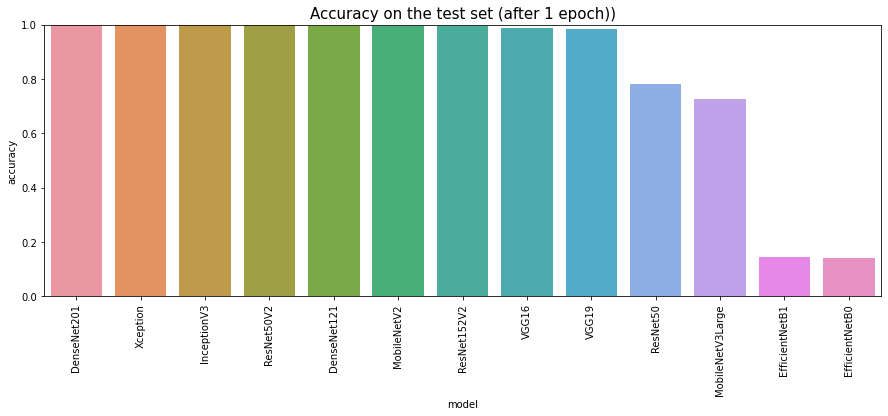

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

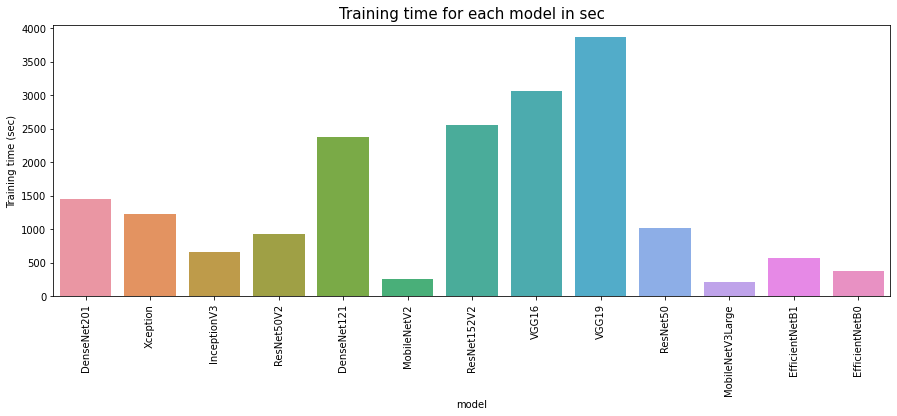

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [ ]:
#좋은 효율을 내는 모델 성능확인(DenseNet201)
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 5589 validated image filenames belonging to 8 classes.
Found 620 validated image filenames belonging to 8 classes.
Found 690 validated image filenames belonging to 8 classes.
Epoch 1/7
175/175 [==============================] - 1649s 9s/step - loss: 0.1016 - accuracy: 0.9723 - val_loss: 0.0290 - val_accuracy: 0.9968
Epoch 2/7
175/175 [==============================] - 1661s 9s/step - loss: 0.0056 - accuracy: 0.9989 - val_loss: 0.0103 - val_accuracy: 0.9984
Epoch 3/7
175/175 [==============================] - 1655s 9s/step - loss: 0.0055 - accuracy: 0.9989 - val_loss: 0.0024 - val_accuracy: 0.9984
Epoch 4/7
175/175 [==============================] - 1606s 9s/step - loss: 6.0443e-04 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 0.9984
Epoch 5/7
175/175 [==============================] - 1610s 9s/step - loss: 1.2115e-04 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9984
Epoch 6/7
175/175 [==============================] - 1591s 9s/step - loss: 6.9020e-05 - accuracy

In [ ]:
#test데이를 통하여 성능확인
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)


labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 99.57%


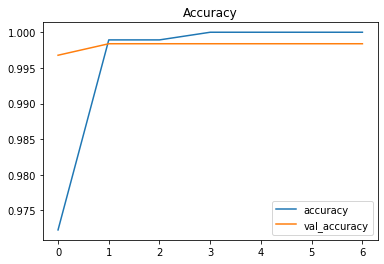

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

번호를 입력하세요 : 104


## 예측률 : 99.98%

### Class prediction = person

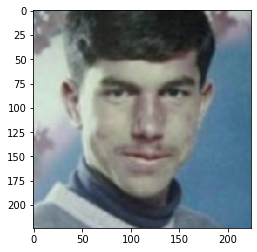

In [ ]:
#모델 예측
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
def printmd(string):
      
    display(Markdown(string))
class_dictionary = {'airplane': 0,
                    'car': 1,
                    'cat': 2,
                    'dog': 3,
                    'flower': 4,
                    'fruit': 5,
                    'motorbike': 6,
                    'person': 7}
IMAGE_SIZE    = (224, 224)
number_1 = int(input("번호를 입력하세요 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"## 예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"### Class prediction = {x}")
    break

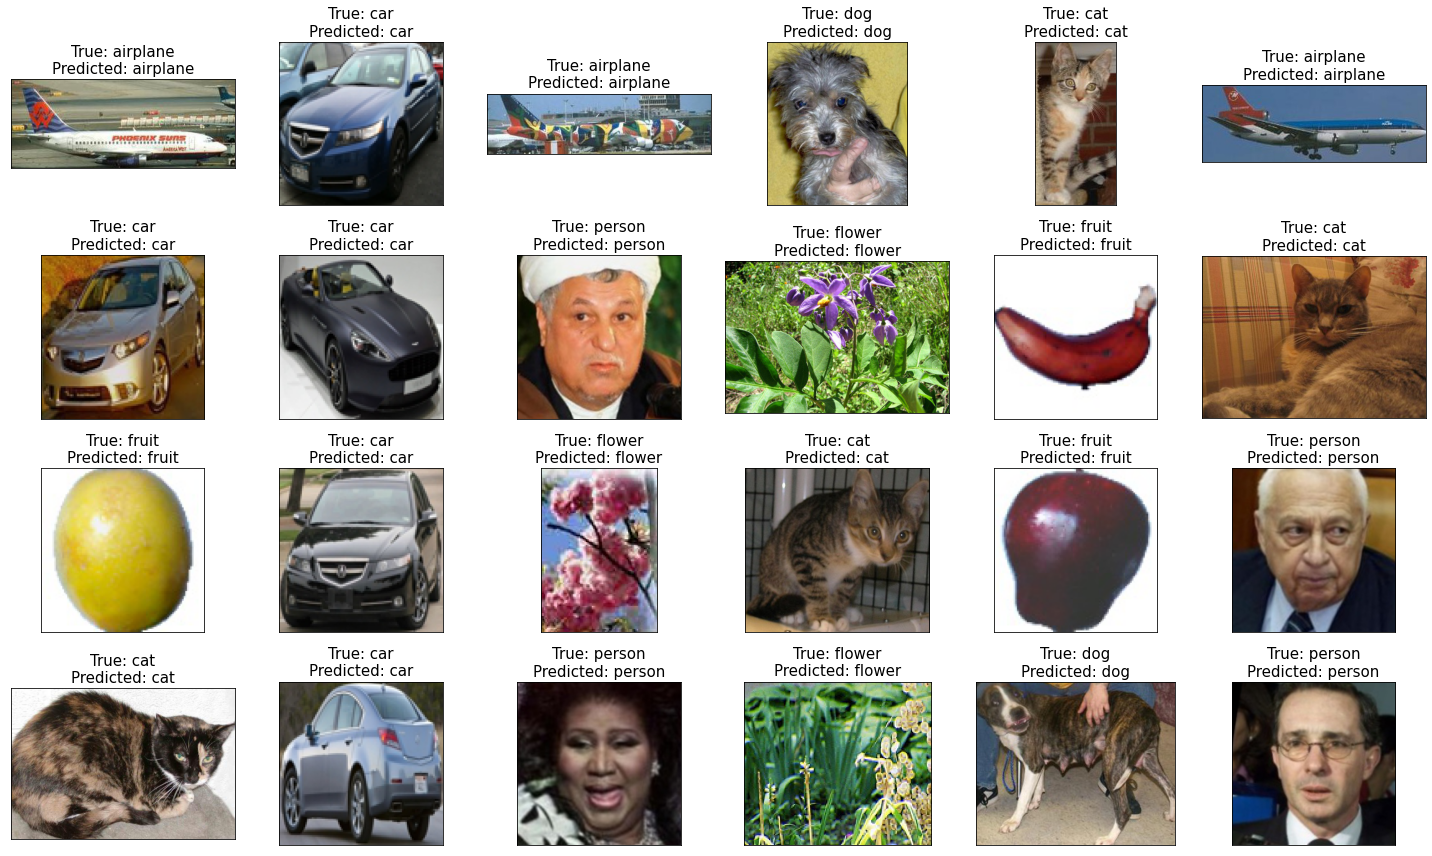

In [ ]:
# 여러 이미지 예측하기
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()